# Анализ рекламных источников игры

## Предобработка данных


- Проверка корректности наименований колонок и приведение их общему виду 
- Проверка типов данных и приведение их к нужному формату
- Создание столбца с днем первого захода в приложение для дальнейшего когортного анализа
- Проверка данных на пропуски, вывление случайных и не случайных пропусков данных, устраниение пропусков если это возможно
- Проверка данных на дубликаты, полные и частичные, устранение
- Проверка данных на выбросы, некорректные и недостоверные значения, обработка данных

In [1]:
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
game_actions = pd.read_csv('/Users/ruslangayfullin/DA_New/YP/project_11_final_games/game_actions.csv')
ad_costs = pd.read_csv('/Users/ruslangayfullin/DA_New/YP/project_11_final_games/ad_costs.csv')
user_source = pd.read_csv('/Users/ruslangayfullin/DA_New/YP/project_11_final_games/user_source.csv')

In [3]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [4]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

In [5]:
game_actions[game_actions['project_type'].isna()==False]['project_type'].unique()

array(['satellite_orbital_assembly'], dtype=object)

In [6]:
 game_actions[game_actions['building_type'].isna()==True]['event'].unique()

array(['finished_stage_1', 'project'], dtype=object)

В датасете `game_actions` содержатся пропуски в типах построенных зданий и типе проекта. 
***
Пропуски в типе строительства связаны с тем, что в данном событии пользователь не совершает действие "строительство", следовательно и тип строительства не возникает. Столбец не требует устранения пропусков
***
Пропуски в типе проекта являются не случайными и заполнены только для события строительства орбитальной станции. Иных типов проектов в датасете нет. Столбец не требует устранения пропусков

In [7]:
# приведение даты к типу datetime
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

In [8]:
#проверка полных дубликатов
game_actions.duplicated().sum()

1

In [9]:
# удалим единственный дубликат
game_actions = game_actions.drop_duplicates().reset_index(drop=True)

In [10]:
#проверка неполных дубликатов
game_actions[['event_datetime','user_id']].duplicated().sum()

0

In [11]:
game_actions['date'] = game_actions['event_datetime'].dt.date
game_actions['month'] = game_actions['event_datetime'].dt.month

In [12]:
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [13]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [14]:
# приведем данные к нужному формату
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

In [15]:
# проверим данные о датах
ad_costs.day.unique()

array(['2020-05-03T00:00:00.000000000', '2020-05-04T00:00:00.000000000',
       '2020-05-05T00:00:00.000000000', '2020-05-06T00:00:00.000000000',
       '2020-05-07T00:00:00.000000000', '2020-05-08T00:00:00.000000000',
       '2020-05-09T00:00:00.000000000'], dtype='datetime64[ns]')

в датасете со стоимостью рекламы видно что записи дат меньше на 1 день чем дни привлечения пользователей. Предположительно, оплата рекламы происходит за 1 день до запуска самой рекламной кампании. Для анализа САС создадим столбец, в котором увеличим все даты на 1 день

In [16]:
ad_costs['first_dt'] = ad_costs['day'] + datetime.timedelta(days=1)
ad_costs['first_dt'] = ad_costs['first_dt'].dt.date

In [17]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


В рамках предобработки данных:
- устранены выявлены и устранены дубликаты в датасете `game_actions`, 
- установлина причина возникновения пропусков,
- Данные даты и времени приведены к нужному типу во всех датасетах
- Создан столбец с корректной датой для датасета `ad_costs`

## Исследовательский анализ данных
- Составление профилей пользователей
- Выявление максимальной и минимальной даты привлечения пользователей
- Определение из каких источников приходят пользователи, и из каких источников пользователей приходит больше всего
- Определение количества пользователей, завершивших первый уровень из общего числа пользователей и по каналам привлечения
- Определить среднее время завершения первого уровня для пользователей по различным каналам привлечения

создадим датасет с профитем пользователей, для которого найедм дату первого посещения сайта, источник привлечения, определим закончил ли пользователь первый уровень и способ завершения первого уровня

In [18]:
#определяем пользователей, которые завершили первый уровень, и определяем тип победы (pvp/pve)
vinners = game_actions[game_actions['event'] == 'finished_stage_1']

pve_vin = game_actions[game_actions['user_id'].isin(vinners['user_id'].unique())
                       & (game_actions['project_type'] == 'satellite_orbital_assembly')]

pvp_vin = game_actions[(game_actions['user_id'].isin(vinners['user_id'].unique()))
                       & (~game_actions['user_id'].isin(pve_vin['user_id'].unique()))]


In [19]:
profiles = (
    game_actions.sort_values(by=['user_id','event_datetime','project_type']).groupby('user_id')
    .agg({'event_datetime':['first','last'],'event':['first','last'], 'project_type':'last'}).reset_index()

)

profiles = profiles.droplevel(0,axis=1)
profiles.columns = ['user_id','first_ts','last_ts','first_event','last_event','project_type']

# создаем столбцы с определением победителей и с определением типа победы
profiles['vinner'] = profiles['user_id'].isin(vinners['user_id'].unique())
profiles['pvp_vin'] = profiles['user_id'].isin(pvp_vin['user_id'].unique())
profiles['pve_vin'] = profiles['user_id'].isin(pve_vin['user_id'].unique())

#определяем дату первого события в игре
profiles['first_dt'] = profiles['first_ts'].dt.date

# добавляем данные об источнике привлечения 
profiles = profiles.merge(user_source, on='user_id', how='left')

# добавляем дату завершения первого уровня игры
profiles = profiles.merge(vinners[['user_id','event_datetime']],on='user_id', how='left')
profiles = profiles.rename(columns={'event_datetime':'finish_ts'})

In [20]:
print('Минимальная дата привлечения пользователей: {}, максимальная дата привлечения пользователей: {}'.format((profiles['first_dt'].min()), (profiles['first_dt'].max())) )

Минимальная дата привлечения пользователей: 2020-05-04, максимальная дата привлечения пользователей: 2020-05-10


In [21]:
# определение доли победителей
vinners_pivot = profiles.pivot_table(
    index='source', values='vinner', aggfunc=['sum','count']).droplevel(1,axis=1).reset_index()
vinners_pivot['vinners_ratio'] = vinners_pivot['sum'] / vinners_pivot['count']
vinners_pivot

,source,sum,count,vinners_ratio
0,facebook_ads,1150,2726,0.421864
1,instagram_new_adverts,1466,3347,0.438004
2,yandex_direct,2042,4817,0.423915
3,youtube_channel_reklama,1159,2686,0.431497


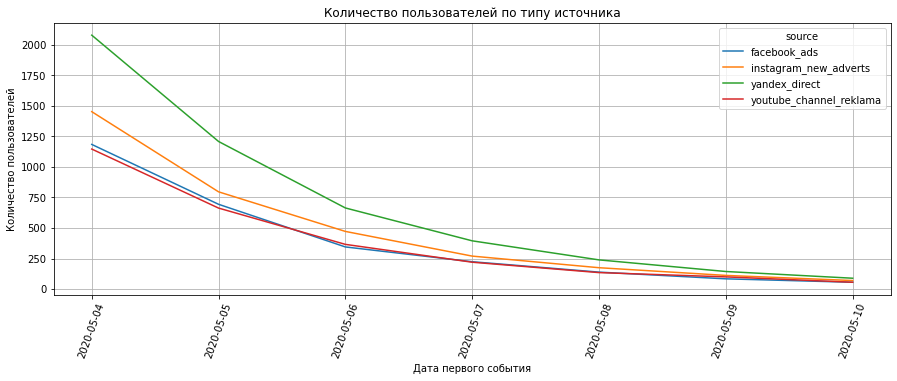

In [22]:
profiles.pivot_table(
    index='first_dt', columns='source', values='user_id', aggfunc='nunique').plot(figsize=(15, 5), grid=True)

plt.ylabel('Количество пользователей')
plt.xlabel('Дата первого события')
plt.xticks(rotation = 70)
plt.title('Количество пользователей по типу источника');
plt.show()

График демонстрирует, что из Яндекса за весь период наблюдения было привлечено больше всего игроков. Наименьшее количество игроков привлечено из источников Youtube и Facebook. С каждой датой наблюдения количество новых игроков снижается по всем каналам. Вероятно это связано со снижением расходов на маркетинг.

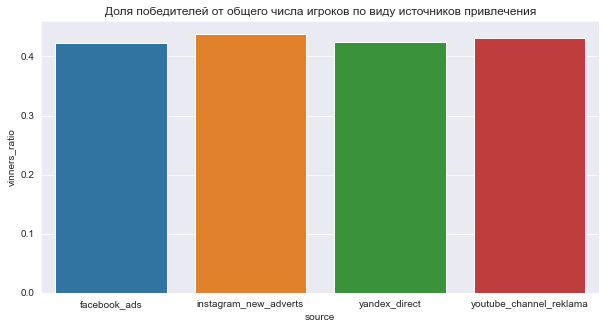

In [23]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
sns.barplot(data=vinners_pivot,x='source',y='vinners_ratio');
plt.title('Доля победителей от общего числа игроков по виду источников привлечения');

Оценивая качественные характеристики привлеченных игроков можно отметить, что количество пользователей, которые перешли на второй уровень сопоставимо по всем видам источников привлечения. Явных лидеров и отстающих не выявленно. Это вероятно свидетельствует о том, что таргет настроен приблизительно одинаково и привлекает представителей похожих целевых аудиторий

In [24]:
vinners_pivot = profiles.pivot_table(
    index='source', values=['vinner','pvp_vin','pve_vin'], aggfunc='sum')

vinners_pivot['pvp_ratio'] = vinners_pivot['pvp_vin'] / vinners_pivot['vinner']
vinners_pivot['pve_ratio'] = vinners_pivot['pve_vin'] / vinners_pivot['vinner']

vinners_pivot

,pve_vin,pvp_vin,vinner,pvp_ratio,pve_ratio
source,,,,,
facebook_ads,391,759,1150,0.660000,0.340000
instagram_new_adverts,476,990,1466,0.675307,0.324693
yandex_direct,620,1422,2042,0.696376,0.303624
youtube_channel_reklama,379,780,1159,0.672994,0.327006


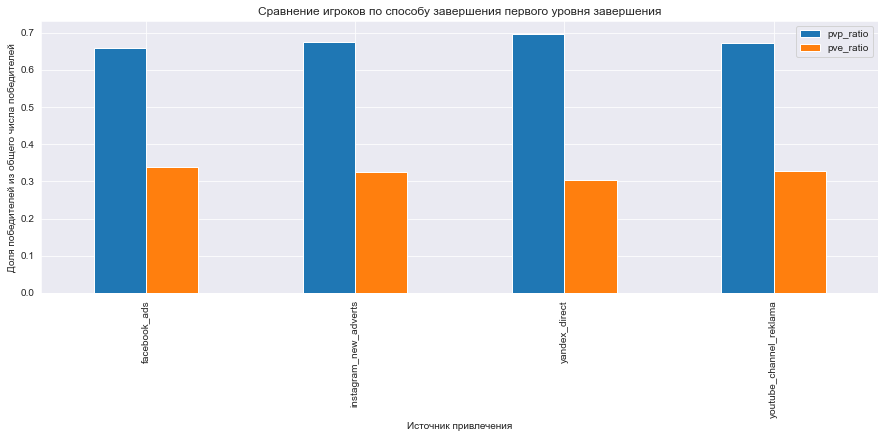

In [25]:
vinners_pivot[['pvp_ratio','pve_ratio']].plot(kind='bar',figsize=(15, 5), grid=True)

plt.xlabel('Источник привлечения')
plt.ylabel('Доля победителей из общего числа победителей')
plt.title('Сравнение игроков по способу завершения первого уровня завершения');
plt.show()

Анализ количества игроков по типу победы явно демонстрирует, что игроков, побеждающих посредством победы над другим игроком (pvp/ player versus player) существенно выше по всем типам источников, чем игроков победивших строительством станции (pve).

In [26]:
profiles['time_delta'] = profiles['finish_ts'].dt.date - profiles['first_ts'].dt.date

profiles['time_delta'] = profiles['time_delta'].apply(lambda x: x.days)

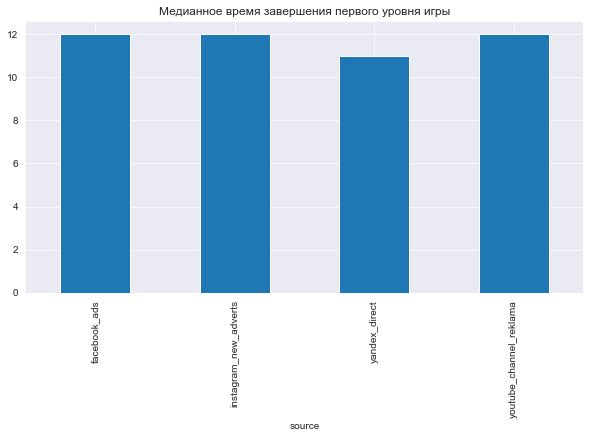

In [27]:
# определим медианное время, за которое игроки доходят до второго уровня
profiles.groupby('source')['time_delta'].median().plot(kind='bar',figsize=(10,5))
plt.title('Медианное время завершения первого уровня игры');

Медианное значение времени, которое требуется игрокам для завершения первого уровня для привлеченных через Яндекс Директ составляет 11 дней, для всех остальных источников - 12 дней.

### Вывод
- Установлено, что пользователи, которые отражены в датасете, привлекались в игру с 4 по 10 мая 2020 года
- В абослютных значениях, больше всего пользователей привлечено из Яндекс директа - 4817 игроков. Количество игроков, прошедших певрый уровень также выше всего среди тех, кто пришел из Яндекс-директа - 2042 игроков. Самые низкие показатели у пользователей, привлеченных  из Youtube.
- В относительных значениях, доля пользователей перешедших на второй уровень сопоставима по всем источникам и находится на уровне 42-43%.  
- Сопоставление победителей по типам побед демонстрирует, что по всем источникам игроки чаще завершают уровень победой над другим игроком. Самый высокий показатель по всем типам побед также у пользователей, привлчеченных через Яндекс Директ
- Медианное время завершения первого уровня для пользователей по различным каналам привлечения также сопоставима и примерно равна. Наиболее выигрышно выглядят данные по Яндексу. Медианное время составляет 11 дней с момента первого события до завершения первого уровня. Для всех остальных источников данный показатель составляет 12 дней

---
В целом анализ показывает, что из Яндекса привлечено больше всего пользователей, однако поведение пользователей из всех источников примерно одинаково. Следовательно, таргет настроен на одинаковые целевые аудитории, однако в случае с Яндекс-Директом он работает эффективнее всего 

## Маркетинг

-  Построение когорт и анализ удержания пользователей по типам источников
- Определить общую сумму расходов на маркетинг.
- Определить самые дорогостоящие и самые дешевые рекламные источники, определить сколько денег было потрачено на каждый рекламный источник
- Рассчет среднего CAC для каждого типа источника
- Расчет конверсии из нового игрока в игрока прошедшего первый уровень по типам источников
- Выявление источников привлечения, из которых привлекаемые игроки строят больше всего объектов
---
Исходя из анализа будут выявляны наиболее эффективные источники привлечения клиентов. Эффективность оценим по количеству проведенного времени и по количеству построенных объектов, так как именно количество построенных объектов в будущем планируется использовать как инструмент монетизации игры.  

In [28]:
# создадим датасет с  лайфтаймами, для дальнейшей группировки когорт
cohorts = profiles.merge(game_actions[['user_id', 'event_datetime']], on='user_id', how='left')

cohorts['lifetime'] = (cohorts['event_datetime'] - cohorts['first_ts']).dt.days


Для того, чотбы когорнтый анализ был корректным, необходимо ограничить данные периодом дней, которые могут "прожить" представители всех когорт.

In [29]:
# рассчитаем горизонт анализа
# вычтем дату максимального привлечения из максимальной даты события 
print('Максимальный лайфтайм, который могут "прожить" пользователи всех когорт составляет {} дней'
      .format((game_actions['date'].max() - profiles['first_dt'].max()).days))


Максимальный лайфтайм, который могут "прожить" пользователи всех когорт составляет 26 дней


In [30]:
# ограничим данные 26 лайфтаймом
cohorts_corr = cohorts.query('lifetime <= 26')


In [31]:
#создадим функцию расчета удержания
def get_retention(df,dimensions=[]):
    
    # рассчитаем количество пользователей в каждой когорте по лайфтайму
    retention = df.pivot_table( index= dimensions, columns='lifetime', values='user_id', aggfunc='nunique')
    
    cohort_sizes = (
    cohorts_corr.groupby(dimensions)
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'}))
    
    retention = cohort_sizes.merge(
    retention, on=dimensions, how='left').fillna(0)
    
    #разделим данные таблицы удержания на размеры когорт
    retention = retention.div(retention['cohort_size'], axis=0).drop(columns=['cohort_size'])
    return retention

In [32]:
#функция построения графиков
def retention_plot (df):
    plt.figure(figsize=(20, 20))
    report = df.drop(columns=[ 0])
    for i, source in enumerate(profiles['source'].unique()):
        report.query('source == @source').droplevel('source').T.plot(grid=True, xticks=list(report.columns.values)
                                                                        ,ax=plt.subplot(4, 2, i + 1))
        plt.xlabel('Лайфтайм')
        plt.ylabel('Доля пользователей')
        plt.title('Кривые удержания для {}'.format(source))

    plt.show()

In [33]:
retention_source =  get_retention(cohorts_corr,['source'])

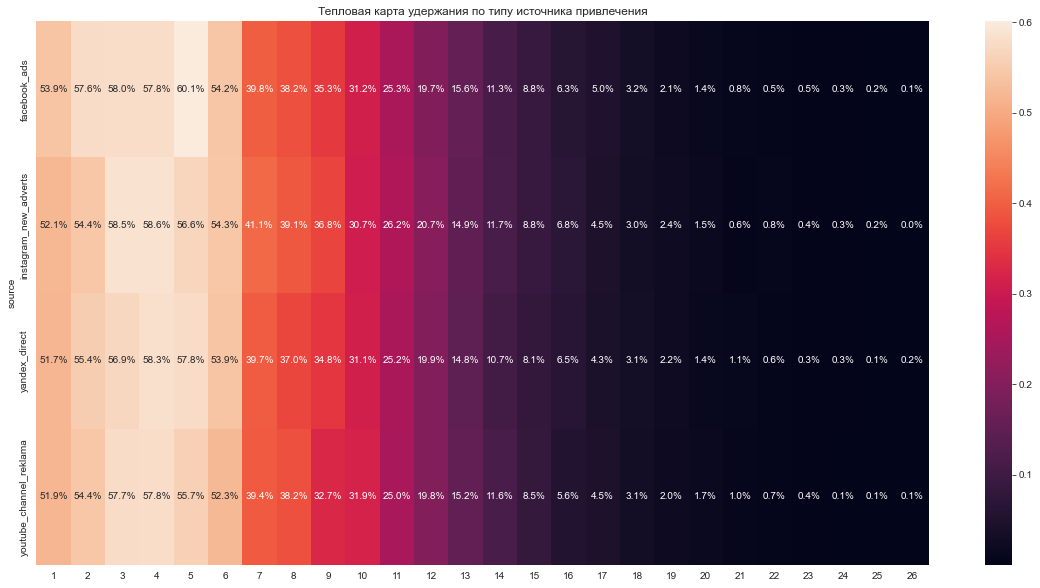

In [34]:
plt.figure(figsize=(20, 10))
sns.heatmap(
    retention_source.drop(columns=[0]),
    annot=True, 
    fmt='.1%',
)
plt.title('Тепловая карта удержания по типу источника привлечения')
plt.show()
        

In [35]:
retention_date = get_retention(cohorts_corr,['source','first_dt'])

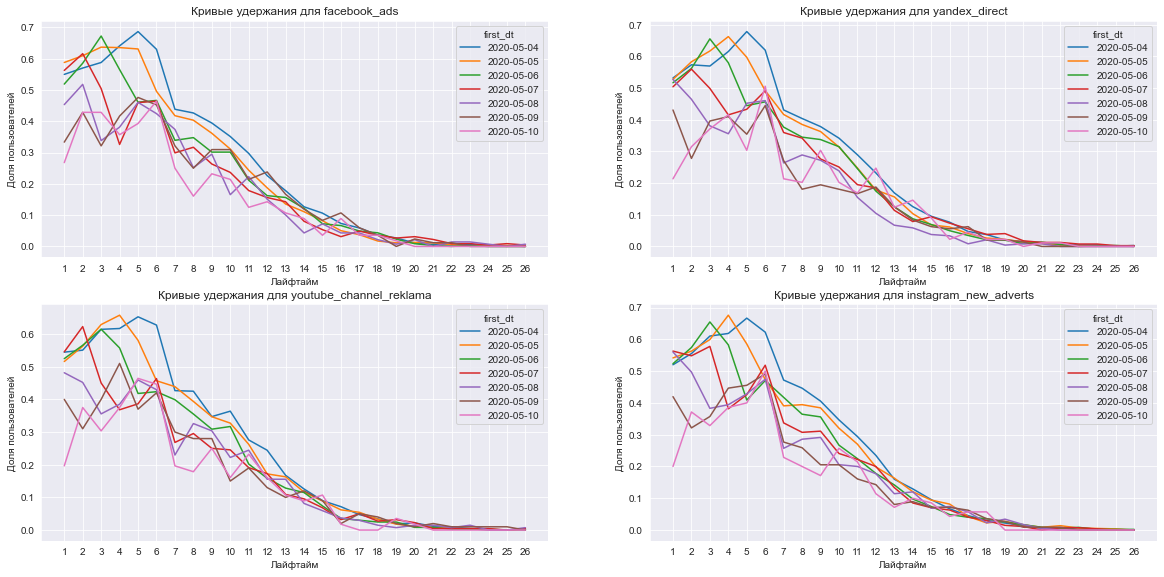

In [36]:
retention_plot(retention_date)

Анализ удержания по когортам первого события в игре показывеает что когорты, привлеченные в первые три дня удерживаются лучше по всем источникам привлечения. Наиболее сильное падение удержания видно после 6 лайфтайма. Кривые удержания по всем источникам показывают сопоставимую динамику. Пик практически по всем когортам приходится на 2-5лайфтайм. нулевой retention к концу исследования говорит нам о том, что за это время все пользователи совершили все свои действия и либо завершили уровень, либо покинули игру.

In [37]:
retention_vinners = get_retention(cohorts_corr,['vinner','source'])


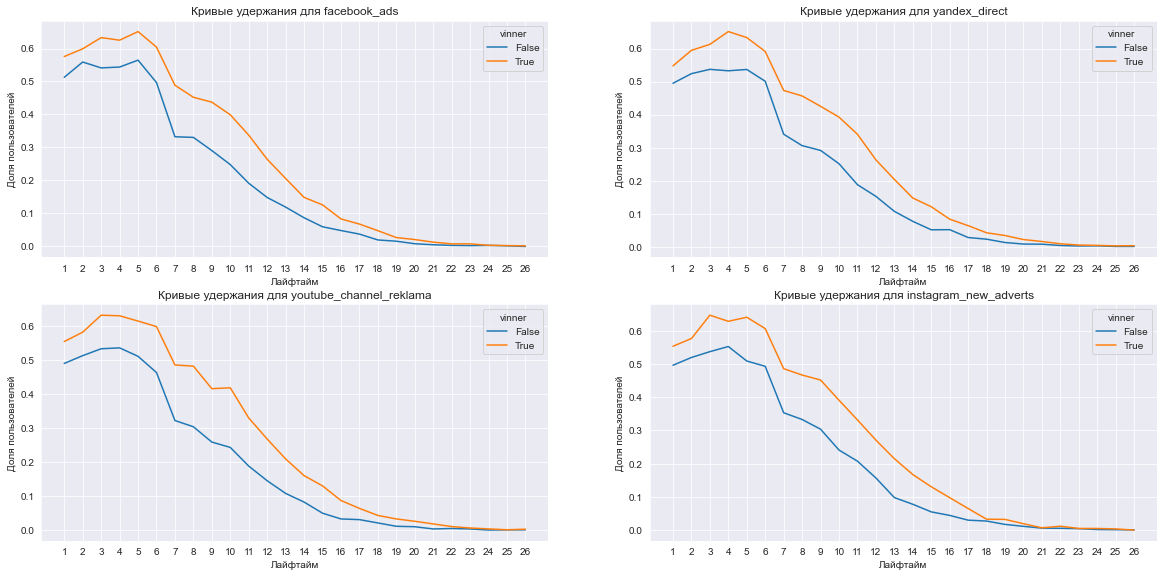

In [38]:
retention_plot(retention_vinners)

Показания удержания игроков, прошедших первый уровень и не прошедших демонстрирует, что те, кто доходит до второго уровня в целом удерживаются лучше по любому из типов источников. Как и в случае с когортами по датам, пик участников наблюдается на 2-4 лайтайм, а резкое падение удержания фиксируется на 6-7 лайфтайм.

определение общей суммы расходов на маркетинг

In [39]:
print('Общая стоимость расходов на рекламу составляет {:.0f} у.е.'.format(ad_costs['cost'].sum()))

Общая стоимость расходов на рекламу составляет 7604 у.е.


Определить самые дорогостоящие и самые дешевые рекламные источники, определить сколько денег было потрачено на каждый рекламный источник

In [40]:
ad_costs.groupby(['source'],as_index=False)['cost'].sum()

,source,cost
0,facebook_ads,2140.904643
1,instagram_new_adverts,2161.441691
2,yandex_direct,2233.111449
3,youtube_channel_reklama,1068.119204


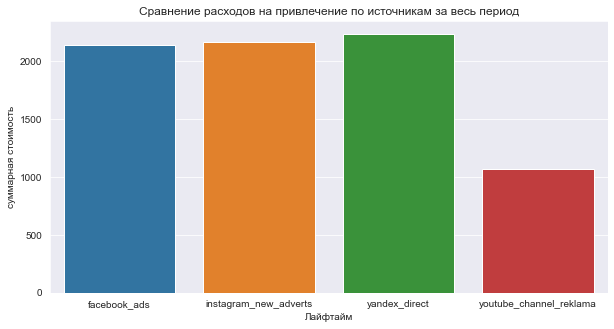

In [41]:
plt.figure(figsize=(10,5))
sns.barplot(data= (ad_costs.groupby(['source'],as_index=False)['cost'].sum()),
           x = 'source',
           y= 'cost')
plt.xlabel('Лайфтайм')
plt.ylabel('суммарная стоимость')
plt.title('Сравнение расходов на привлечение по источникам за весь период');


За весь период наблюдения, на Youtube было потрачено меньше всего средств - 1068 у.е., что почти в 2 раза меньше чем на любой другой канал привлечения. Самая высокая стоимость привлечения у Яндекса, 2233 у.е. При этом расходы на остальные два источника несущественно ниже Яндекса

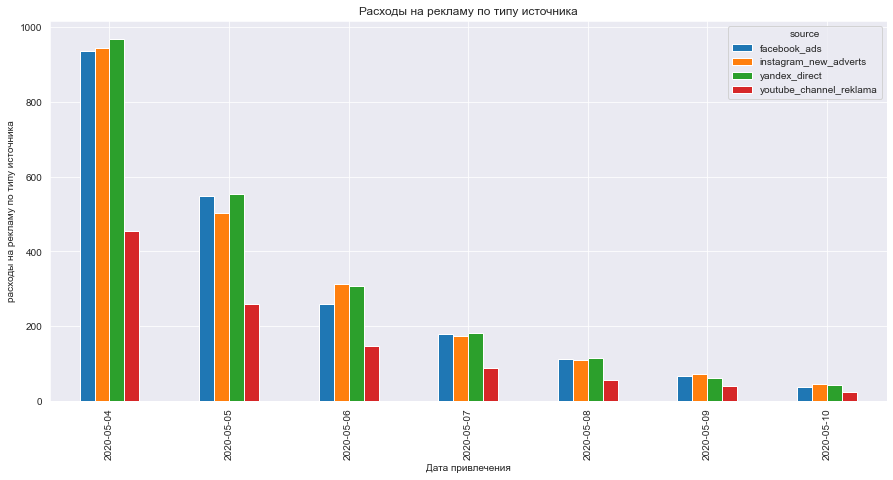

In [42]:
ad_costs.pivot_table(index='first_dt', 
               columns='source',
               values='cost', 
               aggfunc ='sum').plot(kind='bar', 
                                    #stacked=True,
                                    figsize=(15,7))


plt.ylabel('расходы на рекламу по типу источника')
plt.xlabel('Дата привлечения')

plt.title('Расходы на рекламу по типу источника');

plt.show()

Расходы на рекламу сохраняют свои пропорции на протяжении всех дней наблюдения. При этом на графике наглядно видно, что с каждым днем расходы снижаются в 1.5 - 2 раза. Это обуславливает и снижение количества привлеченных пользователей, которое мы зафикисровали ранее

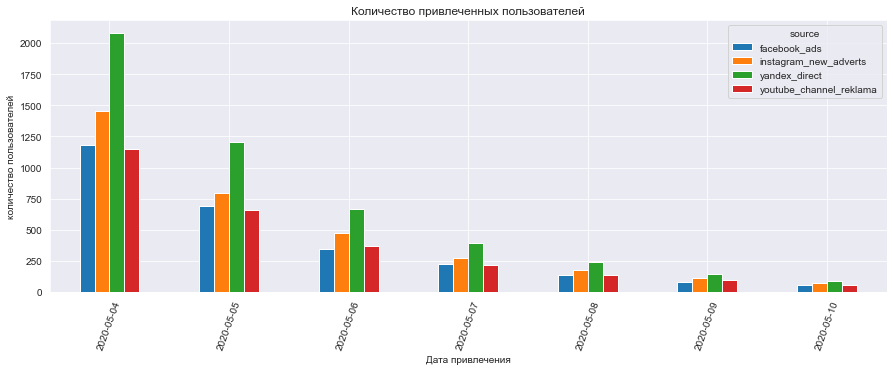

In [43]:
profiles.pivot_table(
    index='first_dt', columns='source', values='user_id', aggfunc='nunique').plot(kind='bar',figsize=(15, 5), grid=True)

plt.ylabel('количество пользователей')
plt.xlabel('Дата привлечения')
plt.xticks(rotation = 70)
plt.title('Количество привлеченных пользователей');

plt.show()

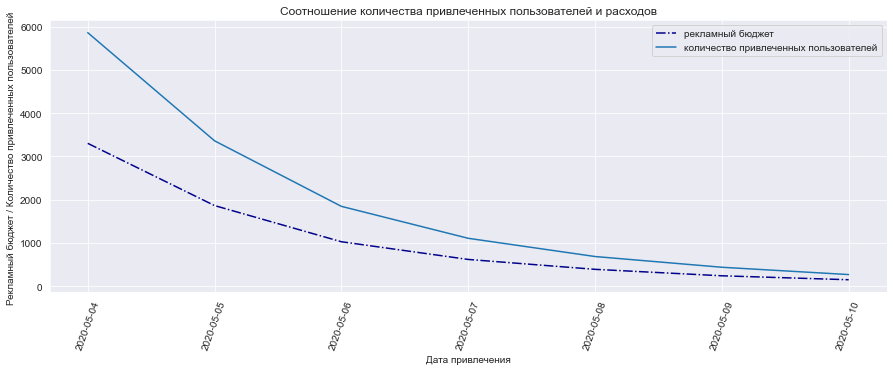

In [44]:
ax1 = ad_costs.pivot_table(index='first_dt',
                     values='cost', 
                     aggfunc='sum').reset_index().plot(kind='line', 
                                                    x = 'first_dt', 
                                                    y = 'cost', linestyle='dashdot', 
                                                    label='сумма расходов на рекламу',
                                                   
                                                   color='darkblue',figsize=(15,7))
profiles.pivot_table(
    index='first_dt', values='user_id', aggfunc='nunique').plot(kind='line', figsize=(15, 5),ax=ax1)


plt.legend(['рекламный бюджет', 'количество привлеченных пользователей'])
plt.ylabel('Рекламный бюджет / Количество привлеченных пользователей ')
plt.xlabel('Дата привлечения')
plt.xticks(rotation = 70)
plt.title('Соотношение количества привлеченных пользователей и расходов');
plt.show()

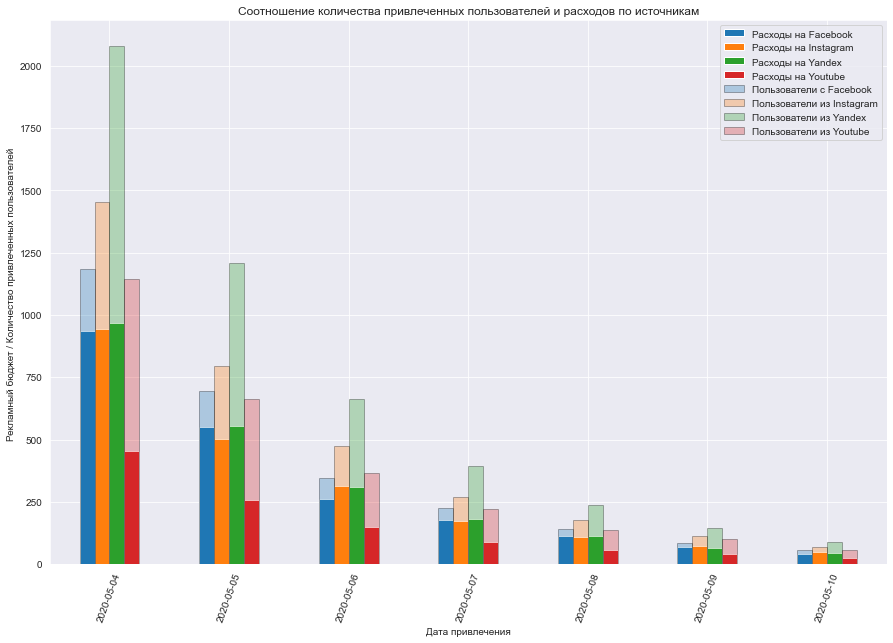

In [45]:
ax1 = ad_costs.pivot_table(index='first_dt', 
               columns='source',
               values='cost', 
               aggfunc ='sum').plot(kind='bar', 
                                    #stacked=True,
                                    figsize=(15,10))

profiles.pivot_table(
    index='first_dt', 
    columns='source', 
    values='user_id', 
    aggfunc='nunique').plot(kind='bar',figsize=(15, 10), alpha = 0.3, ax=ax1, edgecolor='black')


plt.legend(['Расходы на Facebook',
            'Расходы на Instagram',
            'Расходы на Yandex',
            'Расходы на Youtube',
            'Пользователи с Facebook',
            'Пользователи из Instagram',
            'Пользователи из Yandex',
            'Пользователи из Youtube',])

plt.ylabel('Рекламный бюджет / Количество привлеченных пользователей ')
plt.xlabel('Дата привлечения')
plt.xticks(rotation = 70)
plt.title('Соотношение количества привлеченных пользователей и расходов по источникам');

plt.show()

Если оценивать эффективность рекламных источников, видно, что наиболее эффективными каналами привлечения являются Яндекс и Youtube. Не смотря на то, что расходы на Youtube ниже чем на другие источники, он привлекает пользователей на равне с Facebook, на который тратится средств почти столько же, сколько было потрачено на Яндекс Директ.

Рассчет среднего CAC для каждого типа источника

In [46]:
grouped_users = (
        profiles.groupby(['first_dt', 'source'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index())

ad_costs = ad_costs.merge(grouped_users, on = [ 'first_dt','source'], how='left')


In [47]:
ad_costs['acquisition_cost'] = ad_costs['cost'] / ad_costs['unique_users']

In [48]:
ad_costs['first_dt'] = pd.to_datetime(ad_costs['first_dt'])
profiles['first_dt'] = pd.to_datetime(profiles['first_dt'])

profiles = profiles.merge(ad_costs[['first_dt', 
                                    'source', 
                                    'acquisition_cost']], on=['first_dt', 
                                                              'source'],how='left')

In [49]:
CAC = profiles.pivot_table(index='first_dt', 
                           columns='source', 
                           values='acquisition_cost', 
                           aggfunc='mean')
CAC

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
first_dt,,,,
2020-05-04,0.790442,0.649590,0.466381,0.396357
2020-05-05,0.790136,0.631816,0.459149,0.390759
2020-05-06,0.754162,0.665193,0.464206,0.401753
2020-05-07,0.794563,0.641004,0.458018,0.402300
2020-05-08,0.804078,0.628087,0.478784,0.412894
2020-05-09,0.809634,0.639096,0.437234,0.402179
2020-05-10,0.691488,0.668220,0.480669,0.416333


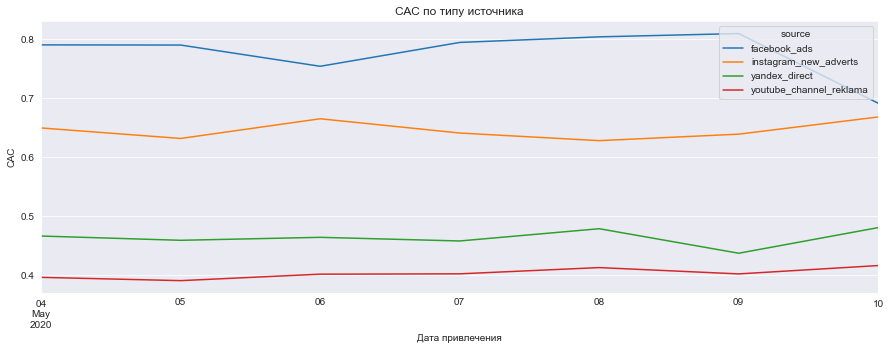

In [50]:
CAC.plot(figsize=(15, 5))

plt.ylabel('САС')
plt.xlabel('Дата привлечения')
plt.title('САС по типу источника')
plt.show()

- Анализ САС подтверждает выводы предыдущего блока. Стоимость привлечения одного пользователя выше всего для источника facebook, на каждого привлеченного пользователя тратится в среднем 0.8 у.е.
- Наиболее эффективными источниками привлечения являются Яндекс и Youtube. На привлечение каждого пользователя тратится менее 0.5 у.е. 

Расчет конверсии из нового игрока в игрока прошедшего первый уровень по типам источников

In [51]:
funnel = profiles.groupby('source').agg({'user_id':'nunique','vinner':'sum','pvp_vin':'sum','pve_vin':'sum'})
funnel = funnel.rename(columns={'user_id':'total_users'})

funnel

,total_users,vinner,pvp_vin,pve_vin
source,,,,
facebook_ads,2726,1150,759,391
instagram_new_adverts,3347,1466,990,476
yandex_direct,4817,2042,1422,620
youtube_channel_reklama,2686,1159,780,379


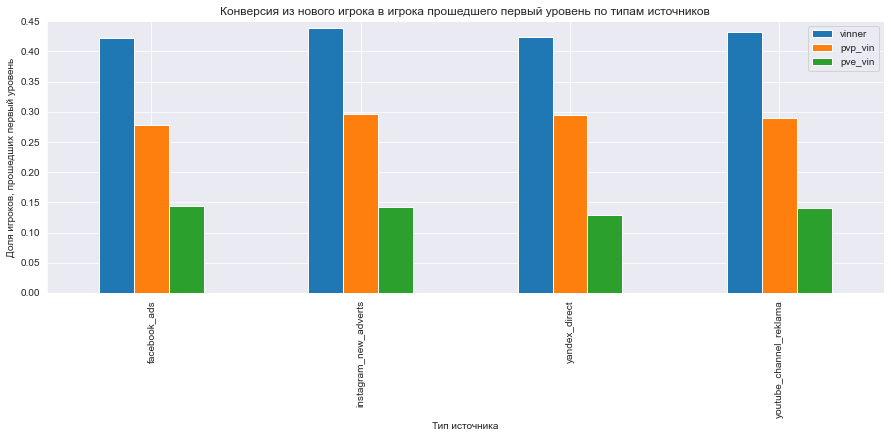

In [52]:
funnel_div = funnel.div(funnel['total_users'],axis=0).drop(columns=['total_users'])


funnel_div.plot(kind='bar',figsize=(15,5))
plt.xlabel('Тип источника')
plt.ylim(0.0,0.45)
plt.ylabel('Доля игроков, прошедших первый уровень')
plt.title('Конверсия из нового игрока в игрока прошедшего первый уровень по типам источников')
plt.show();


Доля игроков, которые проходят первый уровень в целом и различными способами - примерно одинакова для игроков по всем типам источникв.Чаще всего игроки проходят уровень через победу над другим игроком, в 2 раза реже - через строительство станции

Выявление источников привлечения, из которых привлекаемые игроки строят больше всего объектов

In [53]:
builders = (
    game_actions.merge(profiles[['user_id','source']], on='user_id', how='left')
    .query('event=="building"')
    .groupby(['source'],as_index=False).agg({'user_id':'nunique','event':'count'})
    .rename(columns={'user_id':'num_of_users','event':'num_of_buildings'})
    )
builders['avg_buildings'] =  builders['num_of_buildings'] / builders['num_of_users'] 
builders

,source,num_of_users,num_of_buildings,avg_buildings
0,facebook_ads,2726,26131,9.585840
1,instagram_new_adverts,3347,31815,9.505527
2,yandex_direct,4817,45032,9.348557
3,youtube_channel_reklama,2686,24978,9.299330


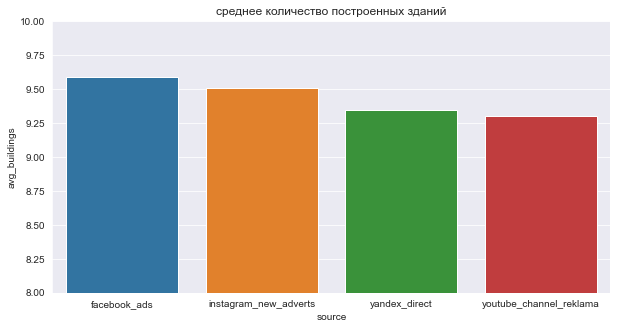

In [54]:
plt.figure(figsize=(10,5))
sns.barplot(data= builders,x='source', y='avg_buildings')
plt.title('среднее количество построенных зданий')
plt.ylim(8,10);

В абсолютных значениях - больше всего зданий построили игроки, привлеченные из Яндекс-Директа, при этом в среднем на одного игрока, показатели для разных источников привлечения различаются несущественно. Больше всего в среднем строят игроки привлеченные из Facebook - 9,58 зданий на 1 игрока. Меньше всего - привлеченные из Youtube - 9.29 зданий на 1 игрока

- Анализ удержания по когортам показывает падение показателя retention после 6 лайфтайма. Значительное количество игроков в этот период уходит из игры, вероятно теряя интерес. Разработчикам рекомендуется принять во внимание этот факт, при дальнейшем развитии игры. В целом, анализируя разные источники привлечения, можно отметить, что удержание не отличается в зависимости от того, откуда приходит игрок.
- Анализ расходов на маркетинг показывает, что меньше всего средств было потрачено на Youtube - почти в 2 раза меньше чем на любой другой канал привлечения. Самая высокая стоимость привлечения у Яндекса. Расходы на маркетинг снижаются каждый день наблюдения, одновременно с этим снижается и количество привлеченных пользователей.
- Эффективность рекламных источников выше всегов Яндекс и Youtube. На Яндекс потрачено больше всего средств, но и привлечено больше всего пользователей. На Youtube средств потрачено минимально, а количество привлеченных пользователей сопоставимо с другимим источниками. Рассчет САС также демонстирует, что стоимость привлечения одного клиента ниже всего у Яндекса и Youtube, а выше всего у Facebook. 
- Анализ конверсии игроков в победителей первого уровня демонстрирует примерно одинаковые результаты для всех типов источников. Количество построект пользователей также не отличается в зависимости от канала привлечения.

## Проверка гипотез
1. Проверим гипотезу о том что время завершения уровня различается в зависимости способа прохождения через реализацию проекта и через победу над первым игроком.  
H0: Статистически значимой разницы во времени между двумя типами игроков нет  
Н1: Существует статистическая разница между двумя типами игроков

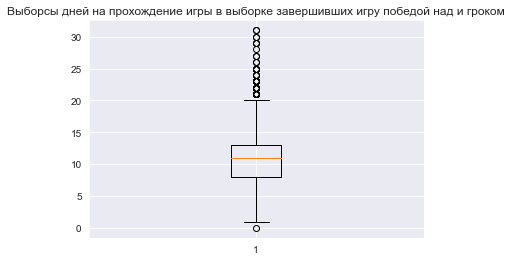

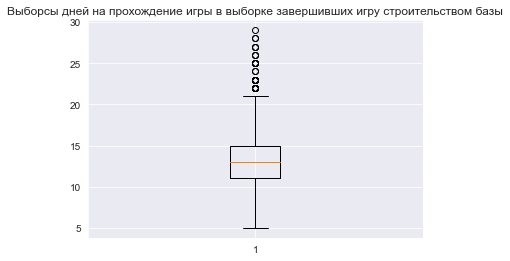

In [55]:
# проверим наличие выбросов в двух выборках игроков
plt.boxplot(profiles[(profiles['vinner'] ==True) & (profiles['pvp_vin'] ==True)]['time_delta']);
plt.title('Выборсы дней на прохождение игры в выборке завершивших игру победой над и гроком')

plt.show()

plt.boxplot(profiles[(profiles['vinner'] ==True) & (profiles['pve_vin'] ==True)]['time_delta'])
plt.title('Выборсы дней на прохождение игры в выборке завершивших игру строительством базы');

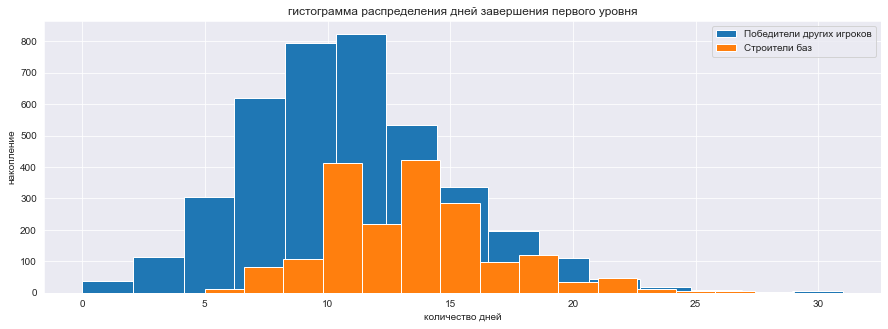

In [56]:
plt.figure(figsize=(15,5))
plt.hist(profiles[(profiles['vinner'] ==True) & (profiles['pvp_vin'] ==True)]['time_delta'],bins=15,label='Победители других игроков');

plt.hist(profiles[(profiles['vinner'] ==True) & (profiles['pve_vin'] ==True)]['time_delta'],bins=15,label='Строители баз')
plt.legend()
plt.xlabel('количество дней')
plt.ylabel('накопление')
plt.title('гистограмма распределения дней завершения первого уровня');

Учитывая тот факт, что мы сравниваем две выборки одной совокупности, в которых есть выбросы, а распределение не является нормальным,  для проверки гипотезы применим непараметрический тест Манна-Уитни

In [57]:
# множество, содержащее время на завершение игры для игроков, завершивших победой над другим игроком
pvp_array = list(profiles[(profiles['vinner'] ==True) & (profiles['pvp_vin'] ==True)]['time_delta'])

# множество, содержащее время на завершение игры для игроков, завершивших победой через строительство базы
pve_array = list(profiles[(profiles['vinner'] ==True) & (profiles['pve_vin'] ==True)]['time_delta'])

alpha = 0.05  

test1 = st.mannwhitneyu(pvp_array, pve_array)

print('p-значение: ', test1.pvalue)

if test1.pvalue < alpha:
    print('Существует статистическая разница между двумя типами игроков')
else:
    print('Статистически значимой разницы во времени между двумя типами игроков нет') 

print()
print('Cреднее значение времени перехода на второй уровень игроков, победивших в pvp меньше на {:.2f} дней, чем у игроков простроивших станцию'
      .format(((profiles[(profiles['vinner'] ==True) & (profiles['pve_vin'] ==True)]['time_delta'].mean())
/(profiles[(profiles['vinner'] ==True) & (profiles['pvp_vin'] ==True)]['time_delta'].mean()))))

p-значение:  4.7866103584542195e-105
Существует статистическая разница между двумя типами игроков

Cреднее значение времени перехода на второй уровень игроков, победивших в pvp меньше на 1.21 дней, чем у игроков простроивших станцию


Тест показал наличие статистической разницы во времени завершения первого уровня между игроками победившими в pvp и pve. Среднее значение времени прохождения уровня через pvp ниже, и при увеличении количества наблюдений наличие статистической разницы будет сохранятьяся

# Вывод
- По итогам анализа определено, что в игру `"Космичческие братья"` с 4 по 10 мая 2020 года привлекались игроки из 4 разных рекламных источников: Facebook, Youtube, Yandex, Instagram. Всего было привлечено 13576 игроков, которые совершили 135640 события. Больше всего пользователей привлечено через Яндекс-Директ, 4817 игроков, меншье всего из Youtube - 2686 игроков. Приерно 40% всех пользователей прошли первый уровень игры. Из них 65-69% прошли уровень за счет победы над противником.
- В целом показатели удержания, показатели конверсии и иные показатели поведения игроков в игре, равно как и проведенные статистические тесты, показывают, что источник привлечения не влияет на качественные характеристики игроков. Независимо от способа привлечения в игру, пользователи в среднем тратят одинаковое количество времени на проходжение, выбирают одни и те же способы проходжения, строят примерно одинаковое количество баз.
- Анализ маркетинговых показателей демонстрирует, что не все источники привлечения одинаково эффективны. Так, стоимость привлечения одного игрока самая низкая у Яндекса и Ютуба. А самая высокая у Фейсбука. И не смотря на то, что на фейсбук и инстаграмм потрачено средств практически столько же сколько и на Яндекс, количество привлеченных игроков из этих источников существенно ниже.  
***
**Презентация с результатами исследования:** <https://drive.google.com/file/d/1e-2He_qY7RBRA6sh4Sg3QHbiAE-bujpY/view?usp=sharing>  
**Cсылка на дашборд:** <https://public.tableau.com/shared/W325CJY8Q?:display_count=n&:origin=viz_share_link>

# Ранжирование
***
В части пересмотра дальнейшей маркетинговой стратегии и соотношения расходов можно сделать следующие рекомендации:
Исходя из анализа можно проранжировать приоритетные источники привлечения следующим образом:
1. Яндекс Директ. Показывает наилучшие показатели привлечения исходя из текущего бюджета. При этом привлекаемые пользователи довольно активно проходят в игру. Медианное время на прохождение первого уровня составляет 11 дней, тогда как у других игроков - 12 дней. 
2. Youtube. Даже при низком бюджете привлекает большое количество игроков, а САС самый низкий. Рекомендуется увеличить объем финансирования данного источника, перераспределив часть средств из менее эффективных каналов
3. Instagram. Является достаточно дорогостоящим источником, однако привлекает пользователей больше чем Facebook
4. Facebook. Самый дорогостоящий источник, обладающий высоким САС, при этом не обеспечивающий действительно большое количество новых пользователей